In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from __init__ import *

utils.rng.set_seed()
device = utils.gpu.set_devices(3)

In [3]:
# Get Data and transforms
tf = transforms.Compose([
    transforms.CenterCrop((384, 384)),
    transforms.Grayscale(),
    transforms.ToTensor()
])


train = datasets.get_coco(transform=tf)
test = datasets.get_coco(transform=tf, train=False)

reshape = nn.AvgPool2d(4)

In [4]:
# Get data parameters
N = len(train)
M1 = 384 * 384
M2 = 96 * 96

# Set training parameters and loader
batch_size = 32
epochs = 48
nu = 1e-3
loader = torch.utils.data.DataLoader(
    train, batch_size=batch_size, shuffle=True, pin_memory=True
)

# Initialize experiment dictionaries
loss_trace = {}
nets = {}
opts = {}


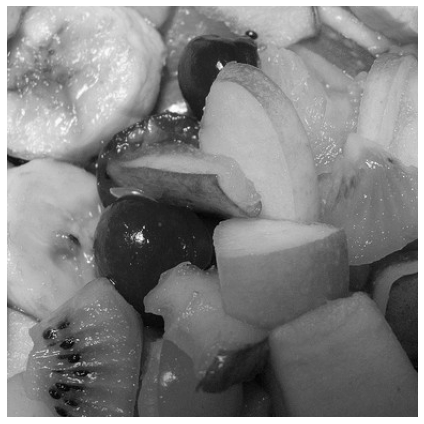

In [5]:
k = 6888
imshow(train[k][0])

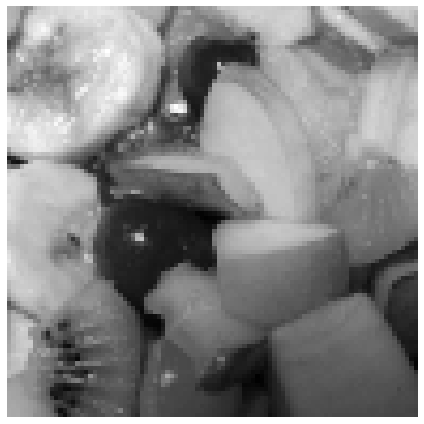

In [6]:
imshow(
    reshape(train[k])[0]
)

In [7]:
Xprime = [] 
for i in tqdm(range(N//10)):
    Xprime.append(train[i][None,...])
        
Xprime = torch.cat(Xprime)
Yprime = reshape(Xprime)

Xprime = Xprime.flatten(-3, -1)
Yprime = Yprime.flatten(-3, -1)

  0%|          | 0/9633 [00:00<?, ?it/s]

In [8]:
noise = torch.randn_like(Yprime) * 0.015

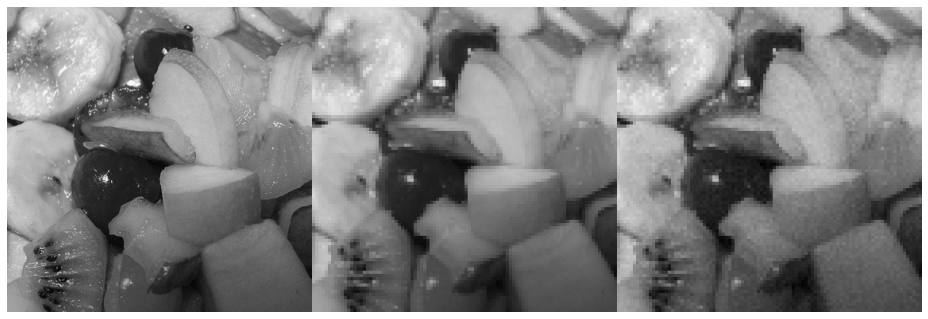

In [36]:
imshow(
    torch.cat([
        Xprime[k].unflatten(-1, (384, 384)),
        F.interpolate(Yprime[k].unflatten(-1, (1, 1, 96, 96)), (384, 384))[0,0],
        F.interpolate((Yprime[k] + noise[k]).unflatten(-1, (1, 1, 96, 96)), (384, 384))[0,0],
    ], dim=1).clip(0,1),
    filename='example_iii_images'
)

In [11]:
U, S, V = torch.linalg.svd(Yprime, full_matrices=False)

In [12]:
W = V.T @ torch.diag(1/S) @ U.T @ Xprime

../ortho/utils/metrics.py:18: UserWarning: Using a target size (torch.Size([1, 384, 384])) that is different to the input size (torch.Size([384, 384])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  mse = F.mse_loss(actual, approx)


PSNR:  3.64472E+01  1.82329E+01
SSIM:  9.05324E-01  2.09680E-01


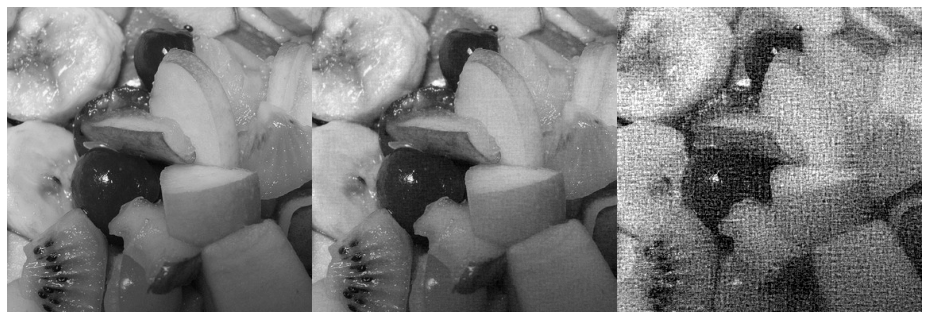

In [14]:
imshow(
    torch.cat([
        Xprime[k].unflatten(-1, (384, 384)),
        (img_sres_ols := (Yprime[k] @ W).unflatten(-1, (384, 384))),
        (img_sres_olsnoise := ((Yprime[k] + noise[k]) @ W).unflatten(-1, (384, 384))),
    ], dim=1).clip(0,1),
    filename='example_iii_ols'
)

print(
    'PSNR: {:12.5E} {:12.5E}'.format(
        utils.metrics.psnr(img_sres_ols.abs(), train[k]).item(),
        utils.metrics.psnr(img_sres_olsnoise.abs(), train[k]).item(),
    )
)

print(
    'SSIM: {:12.5E} {:12.5E}'.format(
        utils.metrics.ssim(
            img_sres_ols.abs()[None,None,...], 
            train[k][None,...]
        ).item(),
        utils.metrics.ssim(
            img_sres_olsnoise.abs()[None,None,...], 
            train[k][None,...]
        ).item(),
    )
)

PSNR:  3.45437E+01  2.21977E+01
SSIM:  8.63791E-01  3.53046E-01


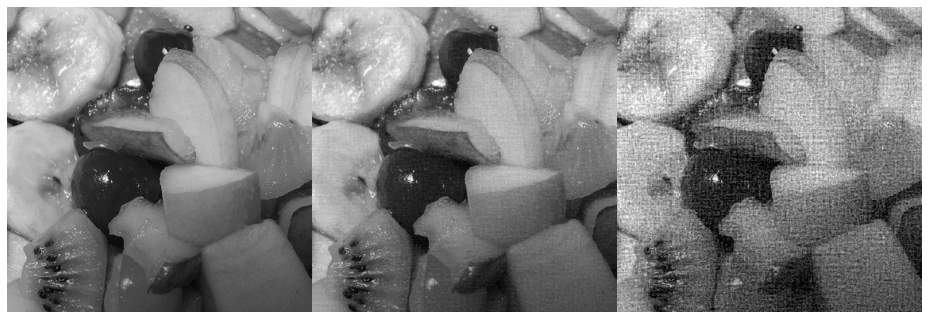

In [15]:
trunc = torch.ones(len(S))
t = 9000
trunc[t:] = 0
Wtrunc = V.T @ torch.diag(trunc/S) @ U.T @ Xprime

imshow(
    torch.cat([
        Xprime[k].unflatten(-1, (384, 384)),
        (img_sres_ols_tsvd := (Yprime[k] @ Wtrunc).unflatten(-1, (384, 384))),
        (img_sres_olsnoise_tsvd := ((Yprime[k] + noise[k]) @ Wtrunc).unflatten(-1, (384, 384))),
    ], dim=1).clip(0,1),
    filename=f'example_iii_tsvd_{t}'
)

print(
    'PSNR: {:12.5E} {:12.5E}'.format(
        utils.metrics.psnr(img_sres_ols_tsvd.abs(), train[k]).item(),
        utils.metrics.psnr(img_sres_olsnoise_tsvd.abs(), train[k]).item(),
    )
)

print(
    'SSIM: {:12.5E} {:12.5E}'.format(
        utils.metrics.ssim(
            img_sres_ols_tsvd.abs()[None,None,...], 
            train[k][None,...]
        ).item(),
        utils.metrics.ssim(
            img_sres_olsnoise_tsvd.abs()[None,None,...], 
            train[k][None,...]
        ).item(),
    )
)

PSNR:  2.86470E+01  2.66798E+01
SSIM:  6.44906E-01  5.50313E-01


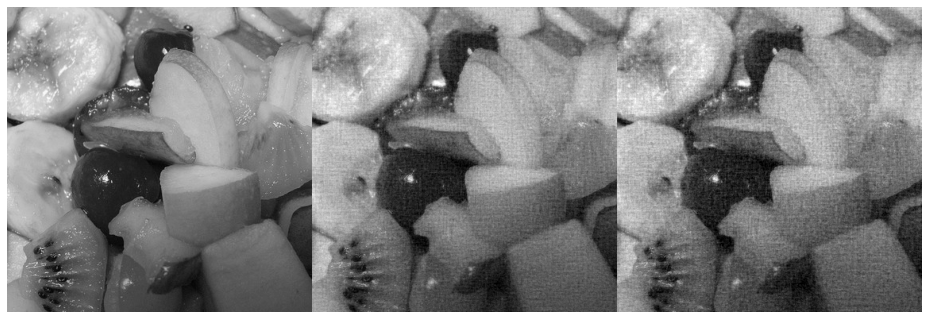

In [16]:
trunc = torch.ones(len(S))
t = 7000
trunc[t:] = 0
Wtrunc = V.T @ torch.diag(trunc/S) @ U.T @ Xprime

imshow(
    torch.cat([
        Xprime[k].unflatten(-1, (384, 384)),
        (img_sres_ols_tsvd := (Yprime[k] @ Wtrunc).unflatten(-1, (384, 384))),
        (img_sres_olsnoise_tsvd := ((Yprime[k] + noise[k]) @ Wtrunc).unflatten(-1, (384, 384))),
    ], dim=1).clip(0,1),
    filename=f'example_iii_tsvd_{t}'
)

print(
    'PSNR: {:12.5E} {:12.5E}'.format(
        utils.metrics.psnr(img_sres_ols_tsvd.abs(), train[k]).item(),
        utils.metrics.psnr(img_sres_olsnoise_tsvd.abs(), train[k]).item(),
    )
)

print(
    'SSIM: {:12.5E} {:12.5E}'.format(
        utils.metrics.ssim(
            img_sres_ols_tsvd.abs()[None,None,...], 
            train[k][None,...]
        ).item(),
        utils.metrics.ssim(
            img_sres_olsnoise_tsvd.abs()[None,None,...], 
            train[k][None,...]
        ).item(),
    )
)

PSNR:  2.74694E+01  2.67873E+01
SSIM:  5.90696E-01  5.56775E-01


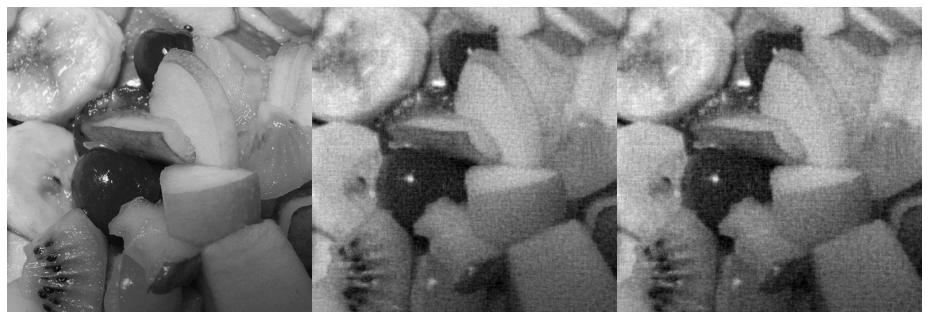

In [17]:
trunc = torch.ones(len(S))
t = 5000
trunc[t:] = 0
Wtrunc = V.T @ torch.diag(trunc/S) @ U.T @ Xprime

imshow(
    torch.cat([
        Xprime[k].unflatten(-1, (384, 384)),
        (img_sres_ols_tsvd := (Yprime[k] @ Wtrunc).unflatten(-1, (384, 384))),
        (img_sres_olsnoise_tsvd := ((Yprime[k] + noise[k]) @ Wtrunc).unflatten(-1, (384, 384))),
    ], dim=1).clip(0,1),
    filename=f'example_iii_tsvd_{t}'
)

print(
    'PSNR: {:12.5E} {:12.5E}'.format(
        utils.metrics.psnr(img_sres_ols_tsvd.abs(), train[k]).item(),
        utils.metrics.psnr(img_sres_olsnoise_tsvd.abs(), train[k]).item(),
    )
)

print(
    'SSIM: {:12.5E} {:12.5E}'.format(
        utils.metrics.ssim(
            img_sres_ols_tsvd.abs()[None,None,...], 
            train[k][None,...]
        ).item(),
        utils.metrics.ssim(
            img_sres_olsnoise_tsvd.abs()[None,None,...], 
            train[k][None,...]
        ).item(),
    )
)

PSNR:  3.16016E+01  2.78410E+01
SSIM:  7.82892E-01  6.14361E-01


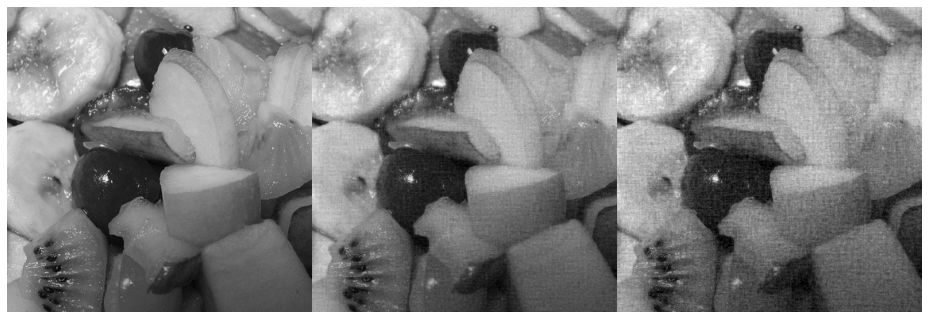

In [18]:
alpha = 1.0
SL2 = S / (S**2 + alpha**2)
Wreg = V.T @ torch.diag(SL2) @ U.T @ Xprime

imshow(
    torch.cat([
        Xprime[k].unflatten(-1, (384, 384)),
        (img_sres_ols_l2 := (Yprime[k] @ Wreg).unflatten(-1, (384, 384))),
        (img_sres_olsnoise_l2 := ((Yprime[k] + noise[k]) @ Wreg).unflatten(-1, (384, 384))),
    ], dim=1).clip(0,1),
    filename=f'example_iii_ols_l2_{int(alpha*100)}'
)

print(
    'PSNR: {:12.5E} {:12.5E}'.format(
        utils.metrics.psnr(img_sres_ols_l2.abs(), train[k]).item(),
        utils.metrics.psnr(img_sres_olsnoise_l2.abs(), train[k]).item(),
    )
)

print(
    'SSIM: {:12.5E} {:12.5E}'.format(
        utils.metrics.ssim(
            img_sres_ols_l2.abs()[None,None,...], 
            train[k][None,...]
        ).item(),
        utils.metrics.ssim(
            img_sres_olsnoise_l2.abs()[None,None,...], 
            train[k][None,...]
        ).item(),
    )
)

PSNR:  2.86129E+01  2.81945E+01
SSIM:  6.95710E-01  6.71673E-01


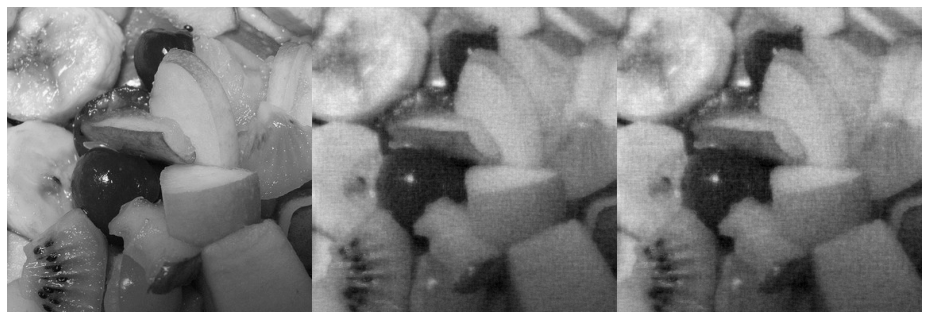

In [19]:
alpha = 5.0
SL2 = S / (S**2 + alpha**2)
Wreg = V.T @ torch.diag(SL2) @ U.T @ Xprime

imshow(
    torch.cat([
        Xprime[k].unflatten(-1, (384, 384)),
        (img_sres_ols_l2 := (Yprime[k] @ Wreg).unflatten(-1, (384, 384))),
        (img_sres_olsnoise_l2 := ((Yprime[k] + noise[k]) @ Wreg).unflatten(-1, (384, 384))),
    ], dim=1).clip(0,1),
    filename=f'example_iii_ols_l2_{int(alpha*100)}'
)

print(
    'PSNR: {:12.5E} {:12.5E}'.format(
        utils.metrics.psnr(img_sres_ols_l2.abs(), train[k]).item(),
        utils.metrics.psnr(img_sres_olsnoise_l2.abs(), train[k]).item(),
    )
)

print(
    'SSIM: {:12.5E} {:12.5E}'.format(
        utils.metrics.ssim(
            img_sres_ols_l2.abs()[None,None,...], 
            train[k][None,...]
        ).item(),
        utils.metrics.ssim(
            img_sres_olsnoise_l2.abs()[None,None,...], 
            train[k][None,...]
        ).item(),
    )
)

PSNR:  2.73136E+01  2.71994E+01
SSIM:  6.78970E-01  6.70789E-01


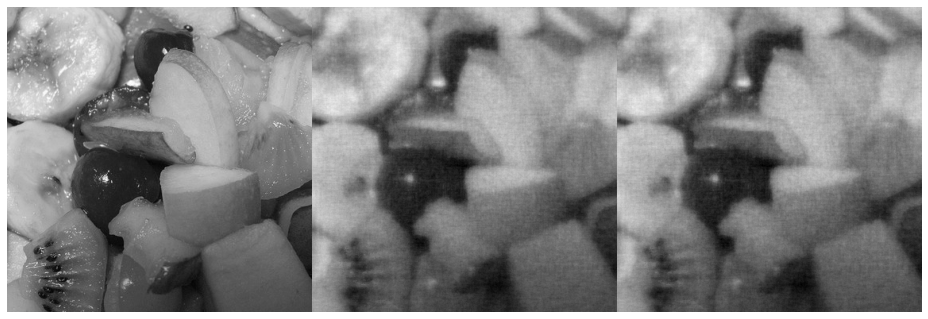

In [20]:
alpha = 10.0
SL2 = S / (S**2 + alpha**2)
Wreg = V.T @ torch.diag(SL2) @ U.T @ Xprime

imshow(
    torch.cat([
        Xprime[k].unflatten(-1, (384, 384)),
        (img_sres_ols_l2 := (Yprime[k] @ Wreg).unflatten(-1, (384, 384))),
        (img_sres_olsnoise_l2 := ((Yprime[k] + noise[k]) @ Wreg).unflatten(-1, (384, 384))),
    ], dim=1).clip(0,1),
    filename=f'example_iii_ols_l2_{int(alpha*100)}'
)

print(
    'PSNR: {:12.5E} {:12.5E}'.format(
        utils.metrics.psnr(img_sres_ols_l2.abs(), train[k]).item(),
        utils.metrics.psnr(img_sres_olsnoise_l2.abs(), train[k]).item(),
    )
)

print(
    'SSIM: {:12.5E} {:12.5E}'.format(
        utils.metrics.ssim(
            img_sres_ols_l2.abs()[None,None,...], 
            train[k][None,...]
        ).item(),
        utils.metrics.ssim(
            img_sres_olsnoise_l2.abs()[None,None,...], 
            train[k][None,...]
        ).item(),
    )
)

In [ ]:
raise ValueError('Stop Here!')

#### Orthogonal Matching Pursuit

Generates a sparse representation of the image.

In [ ]:
A = (torch.pinverse(Xprime) @ Yprime).T
b = Yprime[k]

x = torch.zeros_like(A[0])
solved_mask = torch.zeros_like(A[0]).bool()
max_prev = []

for i in range(A.shape[1]):
    # Determine biggest residual
    r = b - A @ x
    clear_output(wait=True)
    print("{:4d} {:12.5E}".format(i, torch.linalg.norm(r, ord=2).item()))
    cur_max = torch.argmax(torch.abs(A.T @ r))
    solved_mask[cur_max] = 1
    
    if cur_max.item() in max_prev:
        break
    else:
        max_prev.append(cur_max.item())

    # Least squares
    Acur = A[:, solved_mask]    
    x[solved_mask] = torch.pinverse(Acur, rcond=1e-5) @ b


In [ ]:
imshow((A @ x).unflatten(-1, (32, 32)))

In [ ]:
imshow(x.unflatten(-1, (64, 64)))